=== Model Summary ===
Slope (coef): 9345.942443
Intercept   : 26816.192244
R^2 (train): 0.9382
R^2 (test) : 0.9749
MAE (test) : 3426.4269
RMSE (test): 4585.4157
Predicted salary for 5 years experience: 73545.90445964305


/opt/homebrew/lib/python3.13/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


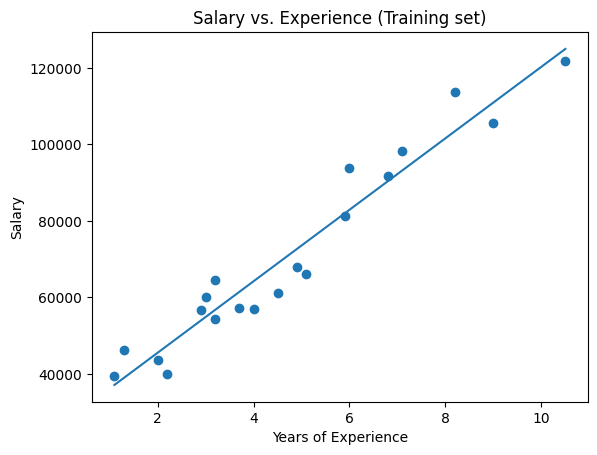

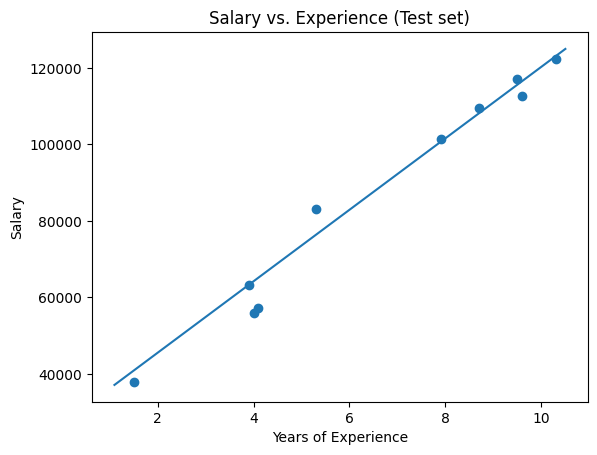

In [1]:
# Simple Linear Regression

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# 1. Load dataset
df = pd.read_csv("Simple-Linear-Dataset.csv")

# Handle column naming differences
expected_x_cols = ["Years_of_Experse", "Years_of_Experience", "Years_of_Expertise"]
x_col = None
for c in expected_x_cols:
    if c in df.columns:
        x_col = c
        break
if x_col is None:
    x_col = df.columns[0]

y_col = "Salary" if "Salary" in df.columns else df.columns[-1]

X = df[[x_col]].values
y = df[y_col].values

# 2. Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3, random_state=0)

# 3. Train model
regressor = LinearRegression()
regressor.fit(X_train, y_train)

# 4. Predictions
y_pred_train = regressor.predict(X_train)
y_pred_test  = regressor.predict(X_test)

# 5. Evaluation
print("=== Model Summary ===")
print(f"Slope (coef): {regressor.coef_[0]:.6f}")
print(f"Intercept   : {regressor.intercept_:.6f}")
print(f"R^2 (train): {r2_score(y_train, y_pred_train):.4f}")
print(f"R^2 (test) : {r2_score(y_test,  y_pred_test):.4f}")
print(f"MAE (test) : {mean_absolute_error(y_test, y_pred_test):.4f}")
print(f"RMSE (test): {mean_squared_error(y_test, y_pred_test, squared=False):.4f}")

# Save predictions
pred_df = pd.DataFrame({
    x_col: X_test.flatten(),
    f"pred_{y_col}": y_pred_test,
    f"actual_{y_col}": y_test
}).sort_values(by=x_col)
pred_df.to_csv("simple_linear_predictions.csv", index=False)

# 6. Visualize training set
plt.figure()
plt.scatter(X_train, y_train)
order = np.argsort(X_train.flatten())
plt.plot(X_train.flatten()[order], y_pred_train[order])
plt.title("Salary vs. Experience (Training set)")
plt.xlabel("Years of Experience")
plt.ylabel("Salary")
plt.savefig("simple_linear_plot_train.png", bbox_inches="tight")

# 7. Visualize test set
plt.figure()
plt.scatter(X_test, y_test)
plt.plot(X_train.flatten()[order], y_pred_train[order])
plt.title("Salary vs. Experience (Test set)")
plt.xlabel("Years of Experience")
plt.ylabel("Salary")
plt.savefig("simple_linear_plot_test.png", bbox_inches="tight")

# 8. Helper function for new predictions
def predict_salary(years_of_experience: float) -> float:
    return float(regressor.predict(np.array([[years_of_experience]]))[0])

# Example usage
print("Predicted salary for 5 years experience:", predict_salary(5.0))


=== Multiple Linear Regression Summary ===
Features used: ['Product_3', 'Location']
R^2 (train): 0.5863
R^2 (test) : 0.3288
MAE (test) : 26792.4675
RMSE (test): 29299.1146

Coefficients (after encoding order):
        feature   coefficient
Location_City_2  -9960.639171
Location_City_3 -15313.830539
      Product_3      0.248546

Intercept: 67017.735195


/opt/homebrew/lib/python3.13/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


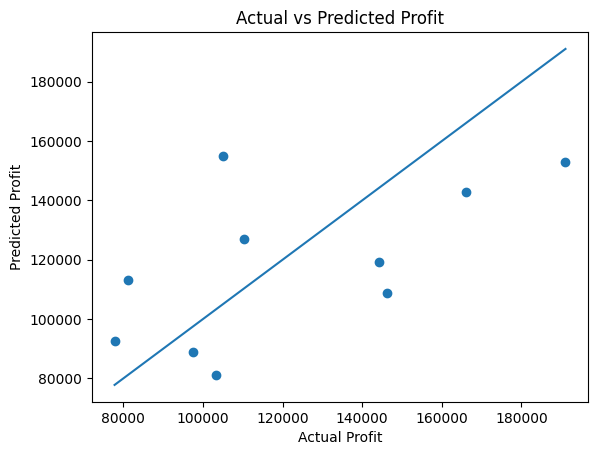

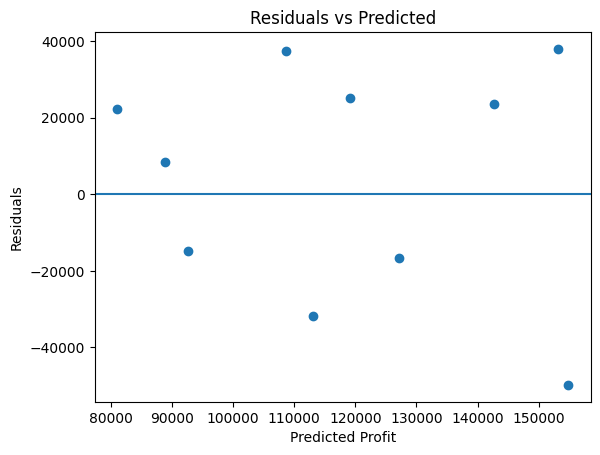

In [2]:
# Multiple Linear Regression

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# -------------------- 0) CONFIG --------------------
FEATURE_CHOICE = 1  # <-- set to 1 or 2 per assignment options

CSV_PATH = "Multiple-Linear-Dataset.csv"
TARGET = "Profit"

OPTION_1_FEATURES = ["Product_3", "Location"]
OPTION_2_FEATURES = ["Product_1", "Product_3"]

# -------------------- 1) Load ----------------------
df = pd.read_csv(CSV_PATH)

# Basic validation / flexibility on column names
expected_cols = {"Product_1", "Product_2", "Product_3", "Location", "Profit"}
missing = expected_cols - set(df.columns)
if missing:
    raise ValueError(f"Dataset missing expected columns: {missing}")

if FEATURE_CHOICE == 1:
    feat_cols = OPTION_1_FEATURES[:]  # copy
elif FEATURE_CHOICE == 2:
    feat_cols = OPTION_2_FEATURES[:]
else:
    raise ValueError("FEATURE_CHOICE must be 1 or 2")

X = df[feat_cols].copy()
y = df[TARGET].values

# -------------------- 2) Build pipeline ------------
# For option 1 we have a categorical 'Location'; for option 2 we don't.
categorical_cols = [c for c in feat_cols if X[c].dtype == "object"]
numeric_cols = [c for c in feat_cols if c not in categorical_cols]

# One-hot encode categorical features (drop='first' to avoid dummy trap)
preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), categorical_cols),
        ("num", "passthrough", numeric_cols),
    ],
    remainder="drop",
)

model = Pipeline(
    steps=[
        ("preprocess", preprocess),
        ("linreg", LinearRegression()),
    ]
)

# -------------------- 3) Train/Test split ----------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0
)

# -------------------- 4) Fit -----------------------
model.fit(X_train, y_train)

# -------------------- 5) Evaluate ------------------
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)

print("=== Multiple Linear Regression Summary ===")
print(f"Features used: {feat_cols}")
print(f"R^2 (train): {r2_train:.4f}")
print(f"R^2 (test) : {r2_test:.4f}")
print(f"MAE (test) : {mae_test:.4f}")
print(f"RMSE (test): {rmse_test:.4f}")

# Extract readable coefficients
lin = model.named_steps["linreg"]
ct = model.named_steps["preprocess"]

# Build feature names post-encoding
feature_names = []
if "cat" in ct.named_transformers_ and hasattr(ct.named_transformers_["cat"], "get_feature_names_out"):
    cat_encoder = ct.named_transformers_["cat"]
    cat_out = list(cat_encoder.get_feature_names_out(categorical_cols))
else:
    cat_out = categorical_cols  # fallback

num_out = numeric_cols
feature_names = cat_out + num_out

coefs = pd.DataFrame({
    "feature": feature_names,
    "coefficient": lin.coef_.ravel()
})
print("\nCoefficients (after encoding order):")
print(coefs.to_string(index=False))
print(f"\nIntercept: {lin.intercept_:.6f}")

# -------------------- 6) Save predictions ----------
pred_df = pd.DataFrame({
    "y_actual": y_test,
    "y_pred": y_pred_test
})
pred_df.to_csv("multiple_linear_predictions.csv", index=False)

# -------------------- 7) Diagnostics plots ----------
# (a) Actual vs Predicted
plt.figure()
plt.scatter(y_test, y_pred_test)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()])
plt.title("Actual vs Predicted Profit")
plt.xlabel("Actual Profit")
plt.ylabel("Predicted Profit")
plt.savefig("y_actual_vs_pred.png", bbox_inches="tight")

# (b) Residuals vs Predicted
residuals = y_test - y_pred_test
plt.figure()
plt.scatter(y_pred_test, residuals)
plt.axhline(0)
plt.title("Residuals vs Predicted")
plt.xlabel("Predicted Profit")
plt.ylabel("Residuals")
plt.savefig("residuals_vs_pred.png", bbox_inches="tight")


/opt/homebrew/lib/python3.13/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/homebrew/lib/python3.13/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/homebrew/lib/python3.13/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/homebrew/lib/python3.13/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the 

=== Polynomial Regression (Level → Salary) ===
Degree 2: R2_train=0.9335  R2_test=0.7055  MAE=111037.84  RMSE=119393.19
Degree 3: R2_train=0.9917  R2_test=0.8721  MAE=71862.09  RMSE=78690.19
Degree 4: R2_train=0.9992  R2_test=0.9693  MAE=28553.55  RMSE=38573.73
Degree 5: R2_train=1.0000  R2_test=0.9944  MAE=12756.76  RMSE=16512.55

Selected degree (highest R^2 on test): 5

Estimated salary at Level=6.5: 171,576.70


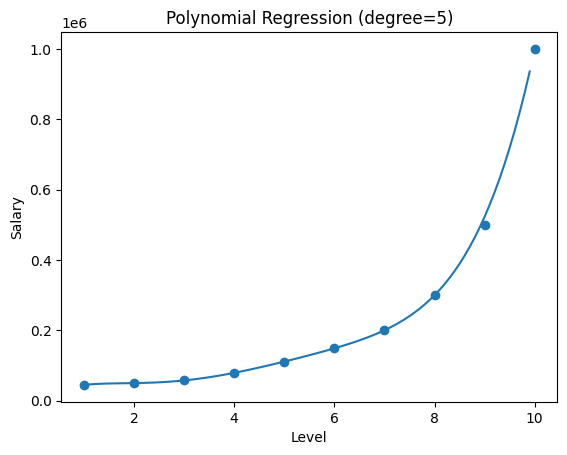

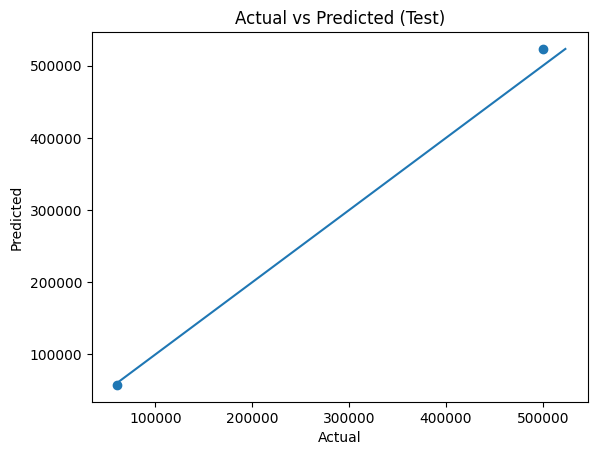

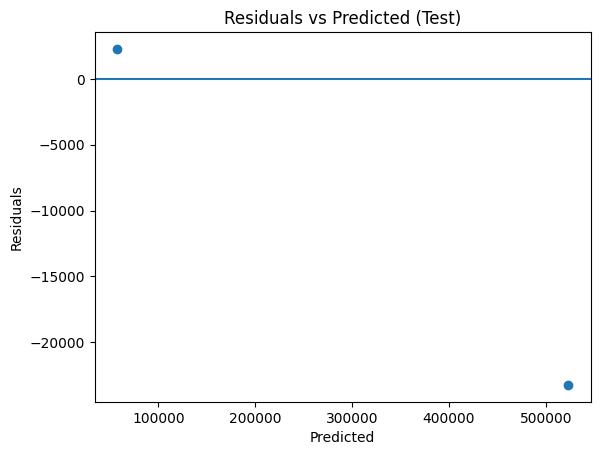

In [5]:
# Polynomial Regression

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# -------------------- 1) Load -----------------------
CSV_PATH = "Polynomial-Dataset.csv"
df = pd.read_csv(CSV_PATH)

# Be a bit robust to column name variations
def pick_col(preferred, fallback_numeric_rule="first"):
    for c in preferred:
        if c in df.columns:
            return c
    # Fallback: pick numeric columns if names differ unexpectedly
    numeric_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
    if not numeric_cols:
        raise ValueError("No numeric columns available.")
    return numeric_cols[0] if fallback_numeric_rule == "first" else numeric_cols[-1]

level_col = pick_col(["Level", "level", "LEVEL"], fallback_numeric_rule="first")
salary_col = pick_col(["Salary", "salary", "SALARY"], fallback_numeric_rule="last")

# Use only Level -> Salary (ignore Position)
X = df[[level_col]].values  # shape (n, 1)
y = df[salary_col].values   # shape (n,)

# -------------------- 2) Split ----------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0
)

# -------------------- 3) Fit degrees 2..5 -----------
degrees = [2, 3, 4, 5]
candidates = []

for d in degrees:
    poly = PolynomialFeatures(degree=d, include_bias=True)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly  = poly.transform(X_test)

    lin = LinearRegression()
    lin.fit(X_train_poly, y_train)

    y_pred_train = lin.predict(X_train_poly)
    y_pred_test  = lin.predict(X_test_poly)

    r2_tr = r2_score(y_train, y_pred_train)
    r2_te = r2_score(y_test,  y_pred_test)
    mae   = mean_absolute_error(y_test, y_pred_test)
    rmse  = mean_squared_error(y_test, y_pred_test, squared=False)

    candidates.append({
        "degree": d,
        "poly": poly,
        "model": lin,
        "R2_train": r2_tr,
        "R2_test": r2_te,
        "MAE_test": mae,
        "RMSE_test": rmse
    })

# Pick the best by highest test R^2
best = max(candidates, key=lambda r: r["R2_test"])
best_d = best["degree"]
best_poly = best["poly"]
best_model = best["model"]

print("=== Polynomial Regression (Level → Salary) ===")
for r in candidates:
    print(f"Degree {r['degree']}: "
          f"R2_train={r['R2_train']:.4f}  R2_test={r['R2_test']:.4f}  "
          f"MAE={r['MAE_test']:.2f}  RMSE={r['RMSE_test']:.2f}")
print(f"\nSelected degree (highest R^2 on test): {best_d}")

# -------------------- 4) Save predictions -----------
X_test_poly_best = best_poly.transform(X_test)
y_pred_test_best = best_model.predict(X_test_poly_best)

pred_df = pd.DataFrame({
    level_col: X_test.flatten(),
    f"pred_{salary_col}": y_pred_test_best,
    f"actual_{salary_col}": y_test
}).sort_values(by=level_col)
pred_df.to_csv("polynomial_predictions.csv", index=False)

# -------------------- 5) Plots ----------------------
# (a) Scatter + best polynomial curve
plt.figure()
plt.scatter(X, y)
X_grid = np.arange(X.min(), X.max(), 0.1).reshape(-1, 1)
y_grid_pred = best_model.predict(best_poly.transform(X_grid))
plt.plot(X_grid, y_grid_pred)
plt.title(f"Polynomial Regression (degree={best_d})")
plt.xlabel(level_col)
plt.ylabel(salary_col)
plt.savefig("polynomial_curve.png", bbox_inches="tight")

# (b) Actual vs Predicted (test)
plt.figure()
plt.scatter(y_test, y_pred_test_best)
lims = [min(y_test.min(), y_pred_test_best.min()),
        max(y_test.max(), y_pred_test_best.max())]
plt.plot(lims, lims)
plt.title("Actual vs Predicted (Test)")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.savefig("poly_actual_vs_pred.png", bbox_inches="tight")

# (c) Residuals vs Predicted (test)
residuals = y_test - y_pred_test_best
plt.figure()
plt.scatter(y_pred_test_best, residuals)
plt.axhline(0)
plt.title("Residuals vs Predicted (Test)")
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.savefig("poly_residuals_vs_pred.png", bbox_inches="tight")

# -------------------- 6) Estimate at Level = 6.5 ----
level_new = 6.5
salary_est = float(best_model.predict(best_poly.transform(np.array([[level_new]])))[0])
print(f"\nEstimated salary at Level={level_new}: {salary_est:,.2f}")

# Optional helper for reuse
def predict_salary_for_level(level_value: float) -> float:
    return float(best_model.predict(best_poly.transform(np.array([[level_value]])))[0])
